In [243]:
import pandas as pd
import numpy as np
from datetime import datetime
import string
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import metrics
import pprint


In [137]:
#load data
gross = pd.read_csv("part2cleanedGrosses.csv", index_col=0)
social = pd.read_csv("part2cleanedSocialMedia.csv", index_col=0)
#pre processing 
social['Date'] = pd.to_datetime(social['Date']).dt.strftime('%Y-%m-%d')
gross['week_ending'] = pd.to_datetime(gross['week_ending']).dt.strftime('%Y-%m-%d')
gross['label'] = [1 if x >= 0 else 0 for x in gross['diff_in_dollars']]
social['Show'] = [re.sub(r'\s+', ' ', x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))).lower().strip()) for x in social['Show']]
#ain't too proud has weird special characters
gross['show'] = [x.split('¡')[0] for x in gross['show']]
#beautiful carol king has different names 
gross['show'] = [re.sub(r'\s+', ' ', x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))).lower().strip()) for x in gross['show']]
gross.loc[gross['show']=='beautiful the carole king musical', 'show']  = 'beautiful'



In [226]:
# Classification Task 1: Grosses - Increase vs. Decrease
# The sale growth of each show for the week is correlated with its social media reactions in previous weeks, 
# predict if growth increased or not in this week. 
# Naive bayes, RF, Decision trees 

In [139]:
gross_date = [x for x in gross['week_ending'].unique() if x[0:4] in ['2019', '2018', '2017']]
temp_date = [x.date().strftime('%Y-%m-%d') for x in list(pd.to_datetime(gross_date) + pd.Timedelta(1, unit='d'))]
#temp_date2 = [x.date().strftime('%Y-%m-%d') for x in list(pd.to_datetime(gross_date) - pd.Timedelta(1, unit='d'))]
gross_date = gross_date + temp_date #+ temp_date2

names = list(social.columns)
names.append('label')
df = pd.DataFrame(columns = names)

for i in social['Date'].unique():
    temp = (pd.to_datetime(i)-pd.Timedelta(7, unit='d')).date().strftime('%Y-%m-%d')
    if temp in gross_date:
        temp_df = social.loc[social['Date'] == temp,:]
        temp_df['label'] = np.nan
        c = gross.loc[(gross['week_ending'] == temp), ['week_ending', 'show', 'label']]
        for j in temp_df.Show:
            for k in c.show:
                if j in k:
                    temp_df.loc[(temp_df['Show'] == j),'label'] = c.loc[c['show'] == k, 'label'].values
                elif k in j:
                    temp_df.loc[(temp_df['Show'] == j),'label'] = c.loc[c['show'] == k, 'label'].values         
    df = df.append(temp_df,ignore_index = True)
    

In [129]:
df_notnull = df.dropna()
X = df_notnull.loc[:, :'FB Checkins'].reset_index(drop=True)
y = df_notnull.loc[:, 'label'].reset_index(drop=True)
#convert categorical data to numerical 
for i in X.columns:
    if type(X[i][0]) == str:
        X[i] = X[i].astype("category").cat.codes
        
normDF = preprocessing.normalize(X, axis=0) 

In [223]:
#decision trees
X_train, X_validate, Y_train, Y_validate = train_test_split(normDF, y, test_size=0.2, random_state=42)

results = []

dt = DecisionTreeClassifier()
kfold = KFold(n_splits= 10, random_state=42, shuffle=False)
cv_results = cross_val_score(dt, X_train, Y_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print("Training", msg)
dt.fit(X_train, Y_train)
predictions = dt.predict(X_validate)
result = "%f " % (accuracy_score(Y_validate, predictions))
print("Testing", result)

Training 0.571257 (0.073213)
Testing 0.666667 


In [180]:
#random forest
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validate = sc.transform(X_validate)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(X_train, Y_train)
y_pred = rf.predict(X_validate)

In [181]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_validate, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_validate, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_validate, y_pred)))
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, Y_train), 
                                                                         rf.score(X_validate, Y_validate)))

Mean Absolute Error: 0.45036601307189544
Mean Squared Error: 0.23205849673202614
Root Mean Squared Error: 0.4817245029392071
R^2 Training Score: 0.86 
R^2 Validation Score: 0.06


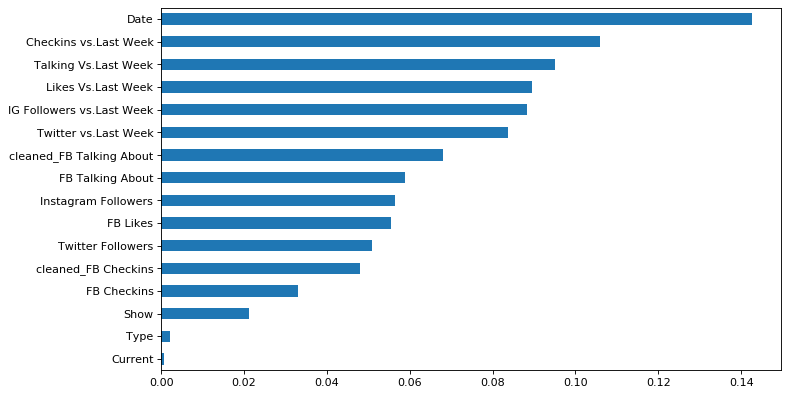

In [194]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

importances = rf.feature_importances_
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh')

In [238]:
#association rule
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules



In [233]:
gross['week_ending'] = pd.to_datetime(gross['week_ending']).dt.strftime('%Y-%m-%d')
itemset = []
for i in gross['week_ending'].unique():
    temp = list(gross.loc[(gross['week_ending']== i) & gross['percent_of_cap'] >= 0.8, 'show'])
    itemset.append(temp)

In [234]:
te = TransactionEncoder()
te_ary = te.fit(itemset).transform(itemset)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [262]:
value = [0.3, 0.5, 0.7]
confidf = pd.DataFrame() 
supportdf = pd.DataFrame()
for i in value:
    frequent_itemsets =  apriori(df, min_support=i,use_colnames=True)
    confi = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
    frequent_itemsets['support_val'] = i
    confi['support_val'] = i
    print(confidf)
    supportdf = supportdf.append(frequent_itemsets)
    confidf = confidf.append(confi.iloc[:,[0,1,5,-1]])
    print('#################### Support =', i, '####################')
    pprint.pprint(frequent_itemsets)
    print('####### Calculating the Confidence #######')
    print(confi.iloc[:,[0,1,5,-1]])

Empty DataFrame
Columns: []
Index: []
#################### Support = 0.3 ####################
     support                                           itemsets  support_val
0   0.385475                             (beauty and the beast)          0.3
1   0.488268                                             (cats)          0.3
2   0.668156                                          (chicago)          0.3
3   0.329050                                      (jersey boys)          0.3
4   0.581564                                  (les mis¨¦rables)          0.3
..       ...                                                ...          ...
70  0.464804  (the phantom of the opera, chicago, wicked, th...          0.3
71  0.328492  (the phantom of the opera, wicked, the lion ki...          0.3
72  0.346927  (the phantom of the opera, wicked, the lion ki...          0.3
73  0.328492  (wicked, the lion king, the phantom of the ope...          0.3
74  0.346927  (wicked, the lion king, the phantom of the op

In [264]:
confidf

,antecedents,consequents,confidence,support_val
0,(beauty and the beast),(chicago),0.801449,0.3
1,(beauty and the beast),(rent),0.840580,0.3
2,(rent),(beauty and the beast),0.896445,0.3
3,(beauty and the beast),(the phantom of the opera),1.000000,0.3
4,(cats),(les mis¨¦rables),0.816934,0.3
...,...,...,...,...
6,"(the phantom of the opera, chicago)",(the lion king),0.956522,0.5
7,"(the phantom of the opera, the lion king)",(chicago),1.000000,0.5
8,"(chicago, the lion king)",(the phantom of the opera),1.000000,0.5
9,(chicago),"(the phantom of the opera, the lion king)",0.956522,0.5


In [236]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
y_pred = classifier.predict(X_validate)

kfold = KFold(n_splits= 10, random_state=42, shuffle=False)
cv_results = cross_val_score(knn, X_train, Y_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print("Training", msg)
dt.fit(X_train, Y_train)
predictions = dt.predict(X_validate)
result = "%f " % (accuracy_score(Y_validate, predictions))
print("Testing", result)


print(confusion_matrix(Y_validate, y_pred))
print(classification_report(Y_validate, y_pred))

Training 0.495902 (0.045674)
Testing 0.679739 
[[39 29]
 [43 42]]
              precision    recall  f1-score   support

         0.0       0.48      0.57      0.52        68
         1.0       0.59      0.49      0.54        85

    accuracy                           0.53       153
   macro avg       0.53      0.53      0.53       153
weighted avg       0.54      0.53      0.53       153

